Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

file_path = "C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration"
os.chdir(file_path)
cwd = os.getcwd()
print(os.listdir(cwd))

['Test', 'Train']


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
training_folder = '//Train//'
test_folder = '//Test//'

data_dir_train = pathlib.Path(file_path + training_folder)
data_dir_test = pathlib.Path(file_path + test_folder)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              labels = "inferred",
                                                              label_mode = "int",
                                                              batch_size = batch_size,
                                                              image_size = (img_height, img_width),
                                                              seed = 123,
                                                              validation_split = 0.2,
                                                              subset = 'training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              labels = "inferred",
                                                              label_mode = "int",
                                                              batch_size = batch_size,
                                                              image_size = (img_height, img_width),
                                                              seed = 123,
                                                              validation_split = 0.2,
                                                              subset = 'training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

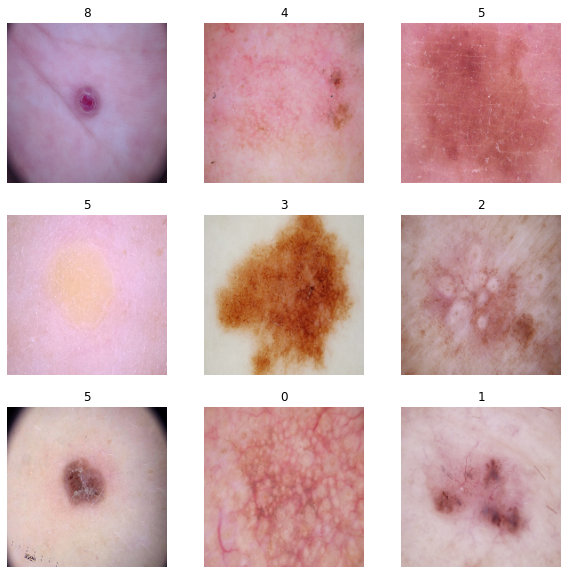

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 59168)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 99s 1s/step - loss: 3.3782 - accuracy: 0.2043 - val_loss: 1.9646 - val_accuracy: 0.2969
Epoch 2/20
56/56 [==============================] - 63s 1s/step - loss: 1.9313 - accuracy: 0.3151 - val_loss: 1.7301 - val_accuracy: 0.3633
Epoch 3/20
56/56 [==============================] - 64s 1s/step - loss: 1.7097 - accuracy: 0.3832 - val_loss: 1.7514 - val_accuracy: 0.3560
Epoch 4/20
56/56 [==============================] - 64s 1s/step - loss: 1.5970 - accuracy: 0.4467 - val_loss: 1.3259 - val_accuracy: 0.5318
Epoch 5/20
56/56 [==============================] - 67s 1s/step - loss: 1.3427 - accuracy: 0.5328 - val_loss: 1.2228 - val_accuracy: 0.5714
Epoch 6/20
56/56 [==============================] - 62s 1s/step - loss: 1.1855 - accuracy: 0.5857 - val_loss: 1.1668 - val_accuracy: 0.5898
Epoch 7/20
56/56 [==============================] - 66s 1s/step - loss: 1.0838 - accuracy: 0.6203 - val_loss: 0.8265 - val_accuracy: 0.7282
Epoch 8/20
56/56 [==

### Visualizing training results

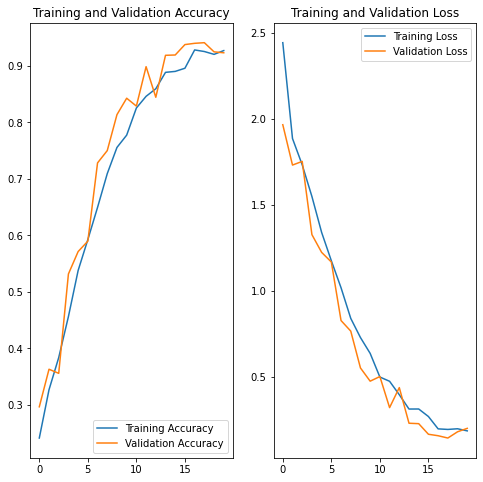

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Question: 
Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Answer:

I have not observed any overfitting and underfitting here, in fact,I believe that this is a very robust model.
Firstly, the accuracy metrics for training and validation are very high, and both are above 93%. 

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3))
  ]
)

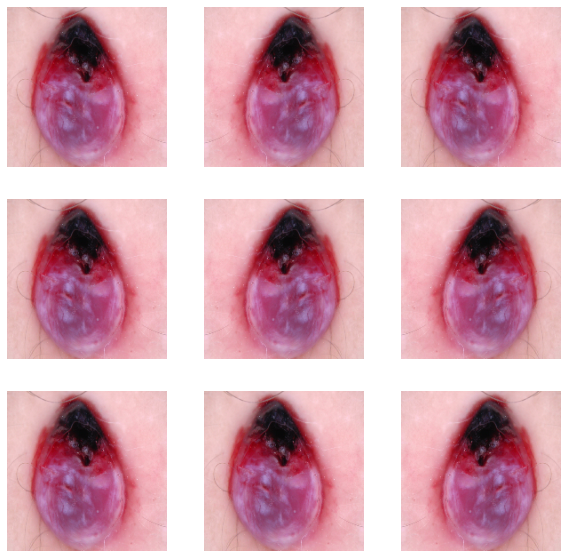

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.models.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])


### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= 20
)

Epoch 1/20
56/56 [==============================] - 67s 1s/step - loss: 3.9278 - accuracy: 0.2038 - val_loss: 1.9025 - val_accuracy: 0.2857
Epoch 2/20
56/56 [==============================] - 65s 1s/step - loss: 1.7761 - accuracy: 0.3464 - val_loss: 1.5357 - val_accuracy: 0.4827
Epoch 3/20
56/56 [==============================] - 65s 1s/step - loss: 1.5395 - accuracy: 0.4602 - val_loss: 1.4206 - val_accuracy: 0.5017
Epoch 4/20
56/56 [==============================] - 64s 1s/step - loss: 1.4004 - accuracy: 0.4936 - val_loss: 1.2641 - val_accuracy: 0.5597
Epoch 5/20
56/56 [==============================] - 64s 1s/step - loss: 1.3876 - accuracy: 0.5022 - val_loss: 1.2576 - val_accuracy: 0.5368
Epoch 6/20
56/56 [==============================] - 66s 1s/step - loss: 1.2347 - accuracy: 0.5648 - val_loss: 1.0693 - val_accuracy: 0.6217
Epoch 7/20
56/56 [==============================] - 64s 1s/step - loss: 1.1384 - accuracy: 0.5948 - val_loss: 1.0912 - val_accuracy: 0.6228
Epoch 8/20
56/56 [==

### Visualizing the results

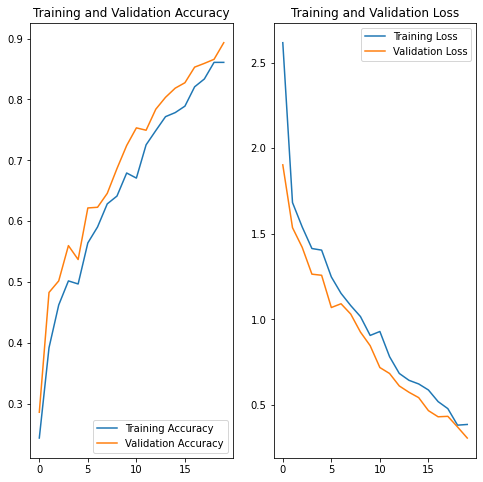

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Question: 
Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Answer:
I see evidences of underfitting, as both training and validation accuracy metrics slowly increased and reached about 83% after 20 epochs. As the instructions only said that we need to train 20 epochs, I stopped here, but seeing that the training and validations slowly increased, I believe that probably trying for 50 epochs will allow us to better observe the progress.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
from collections import Counter

data_classes = np.concatenate([y for x, y in train_ds], axis=0)

Counter(data_classes)

Counter({8: 115, 2: 77, 4: 277, 7: 142, 3: 352, 1: 309, 5: 370, 6: 58, 0: 92})

#### **Todo:** Write your findings here: 
#### - Question
Which class has the least number of samples?

#### Answer:
Class '6', which stands for seborrheic keratosis.

#### - Which classes dominate the data in terms proportionate number of samples?
Class '5', which stands for pigmented benign keratosis.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset= file_path + training_folder
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158E26C19A0>: 100%|██████████| 500/500 [00:03<00:00, 135.10 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158C1E68B20>:   1%|          | 5/500 [00:00<01:12,  6.81 Samples/s]                  

Initialised with 376 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158E25BF940>: 100%|██████████| 500/500 [00:03<00:00, 131.88 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x158E26FA250>:   0%|          | 1/500 [00:00<01:24,  5.90 Samples/s]

Initialised with 95 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158E2714A60>: 100%|██████████| 500/500 [00:03<00:00, 126.62 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x158DA477820>: 100%|██████████| 500/500 [00:19<00:00, 25.47 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x158E2758D00>: 100%|██████████| 500/500 [00:16<00:00, 30.68 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x158DA45BA60>:   3%|▎         | 13/500 [00:00<00:10, 48.22 Samples/s]

Initialised with 462 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158E26C8820>: 100%|██████████| 500/500 [00:03<00:00, 143.22 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x158E27947C0>:   0%|          | 1/500 [00:00<00:57,  8.71 Samples/s]

Initialised with 77 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x158DA45B3D0>: 100%|██████████| 500/500 [00:08<00:00, 60.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158DA48BF70>:   1%|          | 6/500 [00:00<01:04,  7.68 Samples/s]                  

Initialised with 181 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158DA10CF40>: 100%|██████████| 500/500 [00:03<00:00, 136.19 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158E277A730>:   1%|          | 4/500 [00:00<01:06,  7.45 Samples/s]

Initialised with 139 image(s) found.
Output directory set to C://Users//sebas//Assignment CNN//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x158DA48B0D0>: 100%|██████████| 500/500 [00:03<00:00, 127.51 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
import glob 
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_346acbf7-19a0-4f74-88c3-fd262b5d1fd9.jpg',
 'C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6af93831-be34-4195-961a-26ef800ecb8b.jpg',
 'C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_98c552a0-a36b-49ff-bd02-9e6bea4591a3.jpg',
 'C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_cbf7a788-484a-40d6-a75f-3a041890c760.jpg',
 'C:\\Users\\sebas\\Assignment CNN\\CNN_assignment\\Skin

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [28]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
df2

,Path,Label
0,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
1,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
2,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
3,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
4,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,actinic keratosis
...,...,...
4495,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,vascular lesion
4496,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,vascular lesion
4497,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,vascular lesion
4498,C:\Users\sebas\Assignment CNN\CNN_assignment\S...,vascular lesion


In [30]:
#new_df['Label'].value_counts()
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [32]:
data_dir_train= file_path + training_folder 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [34]:
## your code goes here
model = tf.keras.models.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [35]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [36]:
final_epochs = 50
## Your code goes here, use 50 epochs.
history = history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= final_epochs
)# your model fit code

Epoch 1/50
169/169 [==============================] - 206s 1s/step - loss: 2.7906 - accuracy: 0.2629 - val_loss: 1.5503 - val_accuracy: 0.4172
Epoch 2/50
169/169 [==============================] - 209s 1s/step - loss: 1.4976 - accuracy: 0.4285 - val_loss: 1.3666 - val_accuracy: 0.4833
Epoch 3/50
169/169 [==============================] - 211s 1s/step - loss: 1.3349 - accuracy: 0.4970 - val_loss: 1.2287 - val_accuracy: 0.5479
Epoch 4/50
169/169 [==============================] - 232s 1s/step - loss: 1.1998 - accuracy: 0.5609 - val_loss: 1.1754 - val_accuracy: 0.5783
Epoch 5/50
169/169 [==============================] - 208s 1s/step - loss: 1.0316 - accuracy: 0.6237 - val_loss: 1.1949 - val_accuracy: 0.5635
Epoch 6/50
169/169 [==============================] - 218s 1s/step - loss: 0.8785 - accuracy: 0.6871 - val_loss: 0.9733 - val_accuracy: 0.6503
Epoch 7/50
169/169 [==============================] - 220s 1s/step - loss: 0.7303 - accuracy: 0.7480 - val_loss: 0.9907 - val_accuracy: 0.6882

#### **Todo:**  Visualize the model results

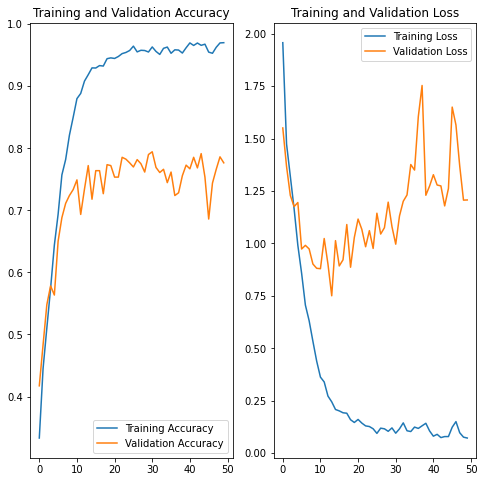

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(final_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Question:** 
Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### Answer:

Unfortuntely I did not get rid of underfitting or overfitting, and the model with the class rebalances has overfitted and I did not find the class rebalancing algorithm helpful.

Personally, I am not a fan of rebalancing class by oversampling a data with fewer samples.
We need to find find more data and add to a class with fewer samples as much as possible because oversampling will not help to have a wider variance in data, as we are just repeating the same data.
We need to do more augmentation, but it may not be help the situation. 